In [15]:
# Do not change this cell
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

num_classes = 4
num_features = 2
random_seed = 1

# Create dataset
X, y = make_blobs(n_samples=10000, n_features=num_features, centers=num_classes, 
                  cluster_std=1.5, random_state=random_seed)

# Convert to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Split dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [ ]:

class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 16)  
        self.relu = nn.ReLU()  
        self.layer2 = nn.Linear(16, output_size)  

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

In [ ]:
def train_step(model, X_train, y_train, loss_fn, optimizer, device):
    model.train()  
    X_train, y_train = X_train.to(device), y_train.to(device)  

    optimizer.zero_grad()  
    y_logits = model(X_train)  
    loss = loss_fn(y_logits, y_train)  

    loss.backward()  
    optimizer.step()  

    y_pred = torch.argmax(y_logits, dim=1)
    accuracy = (y_pred == y_train).float().mean().item()

    return loss.item(), accuracy

In [ ]:
def evaluation_step(model, X_test, y_test, loss_fn, device):
    model.eval()  
    X_test, y_test = X_test.to(device), y_test.to(device)  

    with torch.no_grad(): 
        y_logits = model(X_test)  
        loss = loss_fn(y_logits, y_test)  

        y_pred = torch.argmax(y_logits, dim=1)
        accuracy = (y_pred == y_test).float().mean().item()

    return loss.item(), accuracy


In [ ]:
def train_simple_model(X_train, y_train, X_test, y_test, random_seed):
    # Make device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"  

    torch.manual_seed(random_seed)  # Ensure reproducibility


    model = SimpleModel(input_size=2, output_size=4).to(device)
    loss_fn = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

    
    epochs = 100
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

 
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, X_train, y_train, loss_fn, optimizer, device)
        test_loss, test_acc = evaluation_step(model, X_test, y_test, loss_fn, device)

       
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        
        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return model, train_losses, train_accuracies, test_losses, test_accuracies


In [20]:
def plot_accuracy_performance(train_accuracies, test_accuracies):
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
    plt.plot(epochs, test_accuracies, label="Test Accuracy", marker="s")
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Test Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [21]:
def plot_loss_performance(train_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label="Train Loss", marker="o", color="blue")
    plt.plot(epochs, test_losses, label="Test Loss", marker="s", color="red")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [ ]:

def plot_decision_boundary(model, X_train, y_train):
    model.eval()  
    X_train, y_train = X_train.cpu(), y_train.cpu()  


    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
   
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float)

  
    with torch.no_grad():
        preds = model(grid_tensor)
        preds = torch.argmax(preds, dim=1).numpy()  
 
    preds = preds.reshape(xx.shape)

   
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds, alpha=0.3, cmap=plt.cm.Paired)
    scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors="k")

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary of Trained Model")
    plt.colorbar(scatter)
    plt.show()

In [23]:
# Do not change this cell
model, train_losses, train_accuracies, test_losses, test_accuracies\
    = train_simple_model(X_train, y_train, X_test, y_test, random_seed)

Epoch 1/100: Train Loss: 1.8619, Train Acc: 0.4022, Test Loss: 1.6661, Test Acc: 0.4335
Epoch 2/100: Train Loss: 1.6454, Train Acc: 0.4471, Test Loss: 1.4807, Test Acc: 0.4625
Epoch 3/100: Train Loss: 1.4647, Train Acc: 0.4748, Test Loss: 1.3250, Test Acc: 0.4755
Epoch 4/100: Train Loss: 1.3139, Train Acc: 0.4884, Test Loss: 1.1958, Test Acc: 0.4830
Epoch 5/100: Train Loss: 1.1894, Train Acc: 0.4952, Test Loss: 1.0897, Test Acc: 0.5130
Epoch 6/100: Train Loss: 1.0878, Train Acc: 0.5272, Test Loss: 1.0037, Test Acc: 0.6295
Epoch 7/100: Train Loss: 1.0062, Train Acc: 0.6236, Test Loss: 0.9354, Test Acc: 0.5495
Epoch 8/100: Train Loss: 0.9417, Train Acc: 0.5426, Test Loss: 0.8817, Test Acc: 0.6000
Epoch 9/100: Train Loss: 0.8910, Train Acc: 0.5805, Test Loss: 0.8389, Test Acc: 0.6735
Epoch 10/100: Train Loss: 0.8506, Train Acc: 0.6555, Test Loss: 0.8034, Test Acc: 0.7090
Epoch 11/100: Train Loss: 0.8171, Train Acc: 0.6910, Test Loss: 0.7728, Test Acc: 0.7255
Epoch 12/100: Train Loss: 0.78

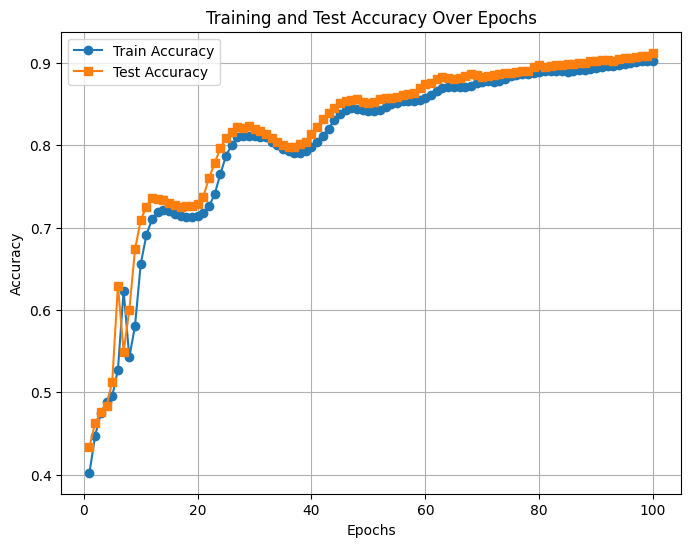

In [24]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, test_accuracies)

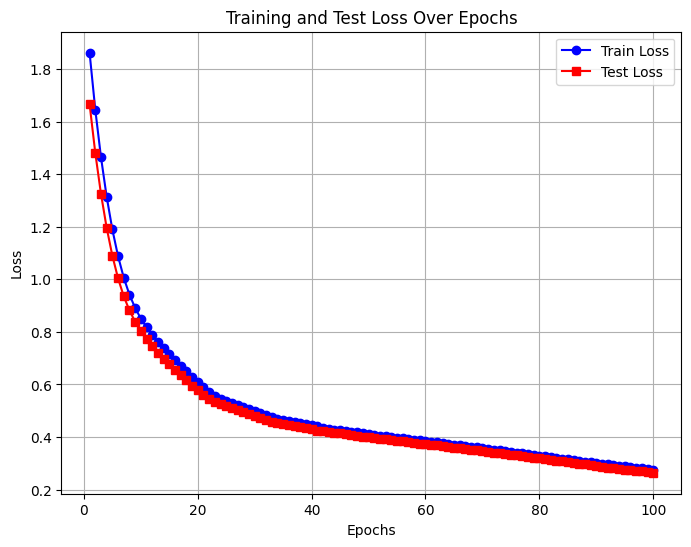

In [25]:
# Do not change this cell
plot_loss_performance(train_losses, test_losses)

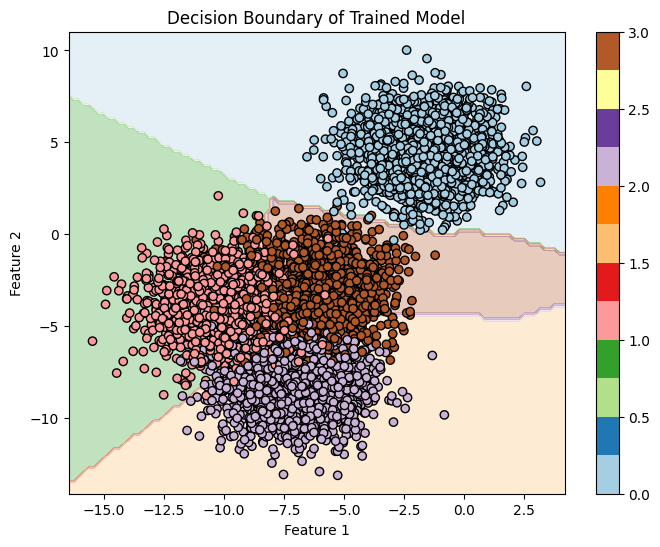

In [26]:
# Do not change this cell
plot_decision_boundary(model, X_train, y_train)